In [5]:
import bart
import cfl
import matplotlib.pyplot as plt
import numpy as np
import pdb

In [6]:
# simulate noiseless phantom data
# todo: mention dims, 5th 'maps' dim
nkyz = 256
nc = 8
ksp_ful_nonoise = bart.bart(1, 'phantom -x {} -k -s {}'.format(nkyz, nc))
ksp_ful_nonoise.shape

(256, 256, 1, 8)

In [7]:
# add noise
noi_var = 3000
seed = np.random.randint(0, 2**63-1)
ksp_ful = bart.bart(1, 'noise -n {} -s {}'.format(noi_var, seed), ksp_ful_nonoise)
ksp_ful.shape

(256, 256, 1, 8)

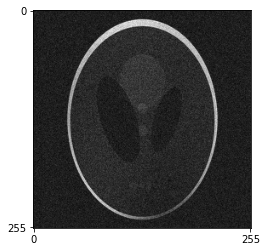

In [8]:
# root-sum-of-squares reconstruction from fully-sampled data
im_ful_coil = bart.bart(1, 'fft -i -u $(bart bitmask 0 1)', ksp_ful)
im_ful_rss = bart.bart(1, 'rss $(bart bitmask 3)', im_ful_coil)

_, ax = plt.subplots()
ax.set_xticks([0, nkyz-1])
ax.set_yticks([0, nkyz-1])
ax.imshow(abs(im_ful_rss), cmap='gray')

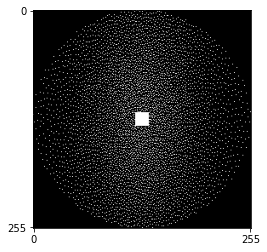

In [9]:
# construct poisson-disk undersampling mask (todo: samples shifted onto cartesian grid?)
# todo: consider discussing -V option (default: 20)
# todo: run cell with different options
acc_y = 3
acc_z = 1.5
calib_dim = 16
mask_args = (nkyz, nkyz, acc_y, acc_z, calib_dim)
mask = bart.bart(1, 'poisson -Y {} -Z {} -y {} -z {} -C {} -v -e'.format(*mask_args))
mask = mask.reshape(nkyz, nkyz)

_, ax = plt.subplots()
ax.set_xticks([0, nkyz-1])
ax.set_yticks([0, nkyz-1])
ax.imshow(abs(mask), cmap='gray')

In [10]:
# apply mask to fully-sampled data
# note: fused multiply and accumulate
# todo: maybe multiple instead
ksp = bart.bart(1, 'fmac', ksp_ful, mask) # todo: note broadcasting

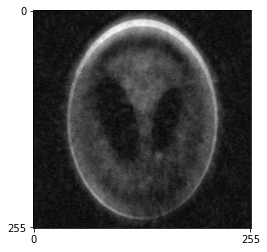

In [11]:
# check effect of masking via simple zero-filled reconstruction
im_coil = bart.bart(1, 'fft -i -u $(bart bitmask 0 1)', ksp)
im_rss = bart.bart(1, 'rss $(bart bitmask 3)', im_coil)

_, ax = plt.subplots()
ax.set_xticks([0, nkyz-1])
ax.set_yticks([0, nkyz-1])
ax.imshow(abs(im_rss), cmap='gray')

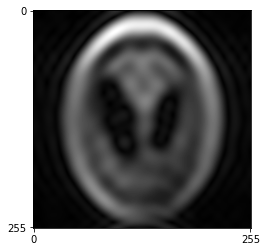

In [16]:
# simulate low-resolution data for coil sensitivity estimation
# todo: consider mentioning compatibility with autocalib 
ksp_smap_nonoise = bart.bart(1, 'phantom -x {} -k -s {}'.format(calib_dim, nc))
seed_smap = np.random.randint(0, 2**63-1)
pad = int((nkyz-calib_dim)/2)
ksp_smap = np.pad(bart.bart(1, 'noise -n {} -s {}'.format(noi_var, seed_smap),
                            ksp_smap_nonoise), ((pad,), (pad,), (0,), (0,)))
# todo: use `bart resize -c 0 256 1 256 input output`

im_coil_smap = bart.bart(1, 'fft -i -u $(bart bitmask 0 1 2)', ksp_smap)
im_rss_smap = bart.bart(1, 'rss $(bart bitmask 3)', im_coil_smap)

_, ax = plt.subplots()
ax.set_xticks([0, nkyz-1])
ax.set_yticks([0, nkyz-1])
ax.imshow(abs(im_rss_smap), cmap='gray')

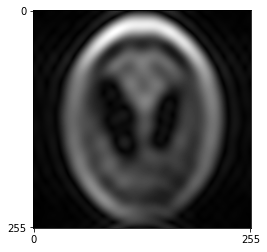

In [23]:
# compress coil sensitivity data to ncc virtual coils
# save coil compression matrix to be used for `ksp` also
# todo: mention other coil compression options
cc_mtx = bart.bart(1, 'cc -M -S', ksp_smap)
ncc = 5
ksp_smap_cc = bart.bart(1, 'ccapply -p {} -S'.format(ncc), ksp_smap, cc_mtx)

im_coil_smap = bart.bart(1, 'fft -i -u $(bart bitmask 0 1 2)', ksp_smap_cc)
im_rss_smap = bart.bart(1, 'rss $(bart bitmask 3)', im_coil_smap)

_, ax = plt.subplots()
ax.set_xticks([0, nkyz-1])
ax.set_yticks([0, nkyz-1])
ax.imshow(abs(im_rss_smap), cmap='gray')

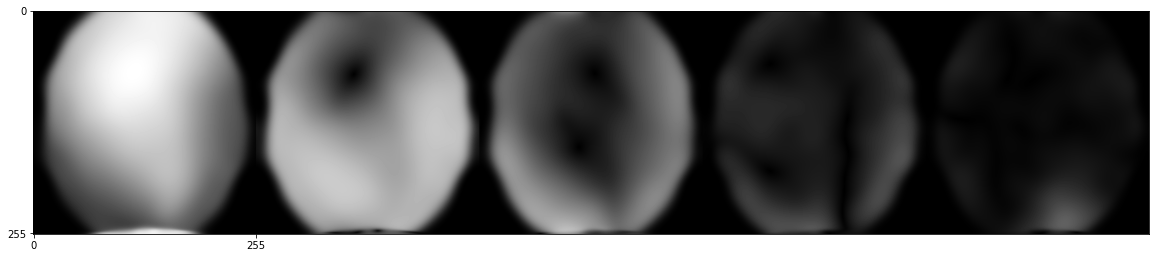

In [44]:
# estimate coil sensitivities via ESPIRiT
smap = bart.bart(1, 'ecalib -m 1 -S', ksp_smap_cc) # -m 1 skips (eig?) maps on 4th dim
_, ax = plt.subplots(figsize=(20,10))
ax.set_xticks([0, nkyz-1])
ax.set_yticks([0, nkyz-1])
ax.imshow(np.concatenate([abs(smap[:,:,0,i]) for i in range(ncc)], 1), cmap='gray')

In [26]:
# compress `ksp` using the same compression matrix
ksp_cc = bart.bart(1, 'ccapply -p {} -S'.format(ncc), ksp, cc_mtx)

In [37]:
# reconstruct using espirit with quadratic regularization
quad_reg = 0.1
im_quad = bart.bart(1, 'pics -R Q:{} -S -d5'.format(quad_reg), ksp_cc, smap)

In [41]:
# reconstruct using espirit with l1-wavelet regularization
wav_reg = 0.2
im_wav = bart.bart(1, 'pics -R W:7:0:{} -S -d5'.format(wav_reg), ksp_cc, smap)

In [39]:
# reconstruct using espirit with l1 total-variation regularization
tv_reg = 0.1
im_tv = bart.bart(1, 'pics -R T:7:0:{} -S -d5'.format(tv_reg), ksp_cc, smap)

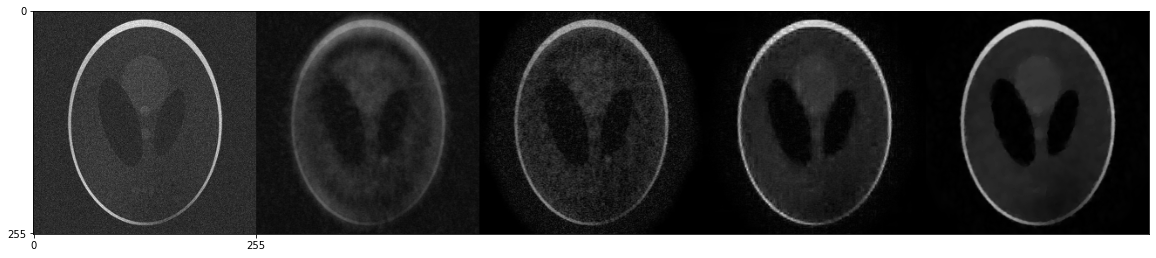

In [43]:
# compare the results
_, ax = plt.subplots(figsize=(20,10))
ax.set_xticks([0, nkyz-1])
ax.set_yticks([0, nkyz-1])
ax.imshow(abs(np.concatenate([im_ful_rss, im_rss, im_quad, im_wav, im_tv], 1)), cmap='gray')